In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from mip.model import *

Using Python-MIP package version 1.6.3


In [2]:
# importing the data to take a look at what we have

df2 = pd.read_csv('../data/family_data.csv',index_col=0)

df2.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [3]:
# load the penalties for days with high traffic
day_penalty = pd.read_csv('day_penalty.txt',sep='\t',index_col=0)['penalty']
day_penalty.head()

day
1     2.4
5     2.4
17    2.4
18    2.4
46    2.4
Name: penalty, dtype: float64

In [4]:
day_penalty[5]

2.4

Load an initially feasible solution for x to see if that speeds up the process. Also, change the performance tuning to optimality

In [5]:
init_sol = pd.read_csv('submission_data/submission_exp_max_diff_30_w1_0_w2_0.4_w3_10.csv',index_col=0)

In [6]:
init_sol = init_sol['assigned_day']
init_sol

family_id
0        52
1        26
2       100
3         2
4        53
       ... 
4995     16
4996     88
4997     32
4998     92
4999     13
Name: assigned_day, Length: 5000, dtype: int64

In [7]:
type(init_sol[0])

numpy.int64

In [8]:
init_sol_dict = {}

for i,k in enumerate(init_sol):
    days_list = [0 for i in range(100)]
    days_list[k-1] = 1
    init_sol_dict[i] = days_list
    

In [9]:
init_sol_dict[2].index(1)

99

In [10]:
# for testing
num_days=100
num_families = 5000

In [11]:
#df2 = df[:num_families].copy()

In [12]:
#people scaling 
people_scale = df2.n_people.sum()/df2.n_people.sum()

max_people = np.around(1.5*df2.n_people.sum()/num_days)
min_people = np.around(df2.n_people.sum()/2/num_days)

if num_days==100 and num_families==5000:
    max_people = 300
    min_people = 125

# day scaling
day_scale = num_days/100

In [13]:
print(max_people)
print(min_people)
print(day_scale)
print(people_scale)

300
125
1.0
1.0


In [14]:
if num_days!=100:
    for c in df2.columns.tolist()[:10]:
        df2[c] = np.random.randint(1,num_days+1,num_families)

In [15]:
df2.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [16]:
# I'm going to add a column which will represent the choice falling outside of any of the given choices. 
# This will be choice_10, and it will be 101,,,

In [17]:
df2.describe()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000
mean,40.715000,41.601000,41.194200,41.595000,41.950600,42.63520,41.965000,42.739600,42.33900,42.608200,4.20060
std,29.054208,29.518375,28.821878,29.094602,29.045049,28.98729,28.711089,28.959156,28.69832,28.116088,1.53272
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,2.00000
25%,16.000000,16.000000,17.000000,17.000000,17.000000,18.00000,17.000000,18.000000,17.00000,19.000000,3.00000
50%,38.000000,38.000000,38.000000,39.000000,39.000000,40.00000,39.000000,39.000000,39.00000,39.000000,4.00000
75%,62.000000,66.000000,63.000000,66.000000,66.000000,66.00000,66.000000,67.000000,66.00000,66.000000,5.00000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.00000,100.000000,8.00000


In [18]:
#df2['choice_0'].hist(bins=[b for b in range(1,num_days+2,1)])

In [19]:
lower_limit = min_people
upper_limit = max_people

# creating the decision variables
choice = ['choice_0','choice_1', 'choice_2', 'choice_3', 'choice_4', 'choice_5', 
          'choice_6', 'choice_7', 'choice_8', 'choice_9','choice_10']
day = [i for i in range(1,num_days+1)]
fam_id = df2.index.tolist()
n_people = df2['n_people'].to_dict()
npd = [n for n in range(min_people,max_people+1,1)]

In [20]:
choice_matrix = {}

for f in fam_id:
    
    if f%100==0:
        print('{}/{}'.format(f,len(df2)))
    
    choice_matrix[f] = {}
    
    for d in day:
        
        choice_to_check = df2.loc[f,df2.columns.tolist()[:10]].values
        
        if d in choice_to_check:
            c_loc = np.where(choice_to_check==d)[0][0]
        else:
            c_loc = 10
            
            
        choice_matrix[f][d] = {c:(0 if i!=c_loc else 1) for i,c in enumerate(choice)} 

0/5000
100/5000
200/5000
300/5000
400/5000
500/5000
600/5000
700/5000
800/5000
900/5000
1000/5000
1100/5000
1200/5000
1300/5000
1400/5000
1500/5000
1600/5000
1700/5000
1800/5000
1900/5000
2000/5000
2100/5000
2200/5000
2300/5000
2400/5000
2500/5000
2600/5000
2700/5000
2800/5000
2900/5000
3000/5000
3100/5000
3200/5000
3300/5000
3400/5000
3500/5000
3600/5000
3700/5000
3800/5000
3900/5000
4000/5000
4100/5000
4200/5000
4300/5000
4400/5000
4500/5000
4600/5000
4700/5000
4800/5000
4900/5000


In [21]:
# gift card contribution by choice
choice_gc = {}
choice_gc['choice_0'] = 0
choice_gc['choice_1'] = 50
choice_gc['choice_2'] = 50
choice_gc['choice_3'] = 100
choice_gc['choice_4'] = 200
choice_gc['choice_5'] = 200
choice_gc['choice_6'] = 300
choice_gc['choice_7'] = 300
choice_gc['choice_8'] = 400
choice_gc['choice_9'] = 500
choice_gc['choice_10'] = 500

# per member monetary contribution
choice_pm = {}
choice_pm['choice_0'] = 0
choice_pm['choice_1'] = 0
choice_pm['choice_2'] = 9
choice_pm['choice_3'] = 9
choice_pm['choice_4'] = 9
choice_pm['choice_5'] = 18
choice_pm['choice_6'] = 18
choice_pm['choice_7'] = 36
choice_pm['choice_8'] = 36
choice_pm['choice_9'] = 36+199
choice_pm['choice_10'] = 36+398


Create a lookup table for the accounting penalty

In [22]:
def accounting_penalty_actual(Nd,Nd1):
    diff = np.abs(Nd-Nd1)
    return 300/max_people*(Nd-min_people)/400 * Nd**(0.5+diff/50)

In [23]:
acc_table = {}
for Nd in npd:
    for Nd1 in npd:
        acc_table[(Nd,Nd1)] = accounting_penalty_actual(Nd,Nd1)

In [24]:
acc_table[(300,125)]

3543750000.0

In [ ]:
#plt.plot(npd,[acc_table[(300,i)] for i in npd])

The decision variable needs to be a boolean for each choice for each family. We will create a 

In [25]:
# set the parameters

max_diff = 30 # this is the maximum difference between two days in total number of people
w1 = 0 # this is the weight applied to the simple difference ppd(d)-ppd(d+1)
w2 = 0.4 # this is the weight applied to the simple linear shopping penalty
w3 = 10 # this is the multiplier for the day penalty for high traffic days

In [26]:
# The prob variable is created to contain the problem data        
m = Model()

In [217]:
m.clear()

In [218]:
# The decision variables are actually the family and the day they are assigned
x = [ [m.add_var(name='fam_{},day_{}'.format(f,d),var_type=BINARY) for d in day] for f in fam_id ]

In [204]:
#e1 = [m.add_var(name='e1_{}'.format(d),var_type=INTEGER) for d in day]
#e2 = [m.add_var(name='e2_{}'.format(d),var_type=INTEGER) for d in day]

In [205]:
#y = [ [ [m.add_var(name='d_{}_nd_{}_nd1_{}'.format(d,nd,nd1),var_type=BINARY)#INTEGER, lb=min_people, ub=max_people)
#         for nd1 in npd]
#       for nd in npd]
#     for d in day]

In [219]:
def ppd_fast(di):
    if di==num_days:
        di = num_days-1
    return xsum(x[fi][di]*n_people[f] for fi,f in enumerate(fam_id))

def ppd(d):
    if d>num_days:
        d=num_days
    di = day.index(d)
    return xsum(x[fi][di]*n_people[f] for fi,f in enumerate(fam_id))

In [220]:
m.objective = 1

#m.objective = minimize(xsum((e1[di]+e2[di]) for di,d in enumerate(day)))

#m.objective = minimize(xsum(x[fi][di]*choice_matrix[f][d][c]*(choice_gc[c] + n_people[f]*choice_pm[c])
#                       for c in choice for di,d in enumerate(day) for fi,f in enumerate(fam_id)))

#                      + xsum(y[di][ndi][nd1i]*acc_table[(nd,nd1)] 
#                             for nd1i,nd1 in enumerate(npd) 
#                             for ndi,nd in enumerate(npd) 
#                            for di,d in enumerate(day)))

#m.objective = minimize(xsum(x[fi][di]*choice_matrix[f][d][c]*(choice_gc[c] + n_people[f]*choice_pm[c])
#                            + ppd_fast(di)*(w1+w2) - w1*ppd_fast(di+1) - w2*125
#         for c in choice for di,d in enumerate(day) for fi,f in enumerate(fam_id))) 

#m.objective = minimize(xsum(x[fi][di]*choice_matrix[f][d][c]*(choice_gc[c] + n_people[f]*choice_pm[c]+w3*day_penalty[d])
#                       for c in choice for di,d in enumerate(day) for fi,f in enumerate(fam_id)))
                       
                      #+ xsum(ppd_fast(di)*(w1+w2) - w1*ppd_fast(di+1) - w2*125 for di,d in enumerate(day))) 

In [221]:
m += xsum(x[fi][di]*choice_matrix[f][d][c]*(choice_gc[c] + n_people[f]*choice_pm[c])
                       for c in choice for di,d in enumerate(day) for fi,f in enumerate(fam_id)) <= 63000

m += xsum(x[fi][di]*choice_matrix[f][d][c]*(choice_gc[c] + n_people[f]*choice_pm[c])
                       for c in choice for di,d in enumerate(day) for fi,f in enumerate(fam_id)) >= 62800

In [222]:
# adding in the constraints

# The first set of constraints ensures each family only has a single day selected
for fi,f in enumerate(fam_id):
        m += xsum(x[fi][di] for di,d in enumerate(day)) == 1

In [223]:
# the second set of constraints guarantee that the total number of visitors is between 125 and 300 for
# for every single day leading up to christmas

for di,d in enumerate(day):
    m += ppd(d) >= min_people, ''
    m += ppd(d) <= max_people, ''

In [224]:
#for di,d in enumerate(day[:]):
#    
#    # each day should only have 1 entry
#    m += xsum(y[di][ndi][nd1i] for nd1i,nd1 in enumerate(npd) for ndi,nd in enumerate(npd)) == 1
#  
#    # the number of people on day d needs to match
#    m += ppd(d) == xsum(y[di][ndi][nd1i]*nd for nd1i,nd1 in enumerate(npd) for ndi,nd in enumerate(npd))

In [225]:

#for di,d in enumerate(day[:-1]):
#    # the number of people on the next day in the sum needs to match the next day
#    m += ppd(d+1) == xsum(y[di][ndi][nd1i]*nd1 for nd1i,nd1 in enumerate(npd) for ndi,nd in enumerate(npd))
    
# the last day needs to have the next day set to the last day number of people
#m += ppd(day[-1]) == xsum(y[-1][ndi][nd1i]*nd1 for nd1i,nd1 in enumerate(npd) for ndi,nd in enumerate(npd))

In [226]:
# adding this third constraint to prevent the difference between each day from climbing too high.

#for di,d in enumerate(day[0:len(day)-1]):
#    m += ppd(d)-ppd(d+1) >= -max_diff, ''
#    m += ppd(d)-ppd(d+1) <= max_diff, ''


In [227]:
#m.max_gap = 0.05
status = m.optimize(max_seconds=8*60*60)

if status == OptimizationStatus.OPTIMAL:
    print('optimal solution cost {} found'.format(m.objective_value))
elif status == OptimizationStatus.FEASIBLE:
    print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
elif status == OptimizationStatus.NO_SOLUTION_FOUND:
    print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))


optimal solution cost 1.0 found


In [228]:
status

<OptimizationStatus.OPTIMAL: 0>

In [229]:
#m.write('model.lp')

In [230]:
obj = m.objective_value
print(obj)

1.0


In [231]:
print(m.num_solutions)

1


In [232]:
fam_day_dict = {}

for i,v in enumerate(m.vars[:int(len(x)*len(x[0]))]):
    
    if i%10000==0:
        print('{}/{}'.format(i,len(m.vars)))
    if abs(v.xi(0)) > 1e-6: # only printing non-zeros
        #print('{} : {}'.format(v.name, v.x))
        s = v.name.split(',')
        fam_day_dict[int(s[0][4:])] = int(s[1][4:])


0/500000
10000/500000
20000/500000
30000/500000
40000/500000
50000/500000
60000/500000
70000/500000
80000/500000
90000/500000
100000/500000
110000/500000
120000/500000
130000/500000
140000/500000
150000/500000
160000/500000
170000/500000
180000/500000
190000/500000
200000/500000
210000/500000
220000/500000
230000/500000
240000/500000
250000/500000
260000/500000
270000/500000
280000/500000
290000/500000
300000/500000
310000/500000
320000/500000
330000/500000
340000/500000
350000/500000
360000/500000
370000/500000
380000/500000
390000/500000
400000/500000
410000/500000
420000/500000
430000/500000
440000/500000
450000/500000
460000/500000
470000/500000
480000/500000
490000/500000


In [233]:
sel_series = pd.Series(fam_day_dict,name='assigned_day')

In [234]:
len(sel_series)

5000

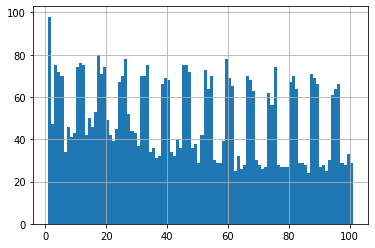

In [235]:
sel_series.hist(bins=[b for b in range(1,num_days+2,1)])

In [236]:
#df2 = df2.join(sel_series)
df2['assigned_day'] = sel_series.astype(int)
#df2['assigned_day'] = df2.assigned_day.astype(int)
df2.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people,assigned_day,assigned_choice
family_id,,,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4,52,choice_0
1,26,4,82,5,11,47,38,6,66,61,4,26,choice_0
2,100,54,25,12,27,82,10,89,80,33,3,100,choice_0
3,2,95,1,96,32,6,40,31,9,59,2,2,choice_0
4,53,1,47,93,26,3,46,16,42,39,4,53,choice_0


In [237]:
df2[df2.assigned_day.isnull()]

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people,assigned_day,assigned_choice
family_id,,,,,,,,,,,,,


In [238]:
total_people = {}
for d in day:
    mask = df2['assigned_day']==d
    total_people[d] = df2[mask].n_people.sum()
    print(total_people[d])

298
194
300
296
296
155
205
173
186
296
295
297
196
209
203
218
298
300
293
193
173
177
217
298
297
290
230
184
202
157
298
297
293
149
158
135
137
257
285
277
142
143
164
140
288
299
264
165
174
130
196
299
268
293
137
132
130
171
298
276
270
130
132
128
125
292
295
252
132
129
125
126
275
224
300
130
125
125
126
295
288
248
127
129
129
127
296
282
295
130
132
127
126
264
271
264
128
126
127
130


Calculating the actual objective for the problem

In [239]:
def accounting_penalty_actual(Nd,diff):
    return 300/max_people*(Nd-min_people)/400 * Nd**(0.5+np.fabs(diff)/50)

In [240]:
total_accounting_penalty = sum([accounting_penalty_actual(total_people[d],total_people[d]-total_people[d+1])
                                if d<100 
                                else accounting_penalty_actual(total_people[d],0)
                                for d in day])
print(total_accounting_penalty)

3651548586.156717


In [241]:
# Adding a column to the dataframe for the choice made...

def choice_func(r):
    if r['assigned_day'] in r.values[:10]:
        return choice[list(r.values[:10]).index(r.assigned_day)]
    else:
        return 'choice_10'

In [242]:
df2['assigned_choice'] = df2.apply(choice_func,axis=1)
df2[df2.assigned_choice=='choice_4'].head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people,assigned_day,assigned_choice
family_id,,,,,,,,,,,,,
110,67,22,24,23,70,9,47,43,1,89,6,70,choice_4
1176,54,26,1,12,100,66,16,33,24,53,8,100,choice_4
1436,96,1,49,95,69,32,48,30,3,81,8,69,choice_4
1959,50,24,96,26,83,61,84,53,80,25,7,83,choice_4
2069,17,95,25,18,83,14,1,10,6,26,5,83,choice_4


In [243]:
def simple_cost(r):
    return choice_gc[r['assigned_choice']] + r['n_people']*choice_pm[r['assigned_choice']]

In [244]:
total_simple_cost = df2.apply(simple_cost,axis=1).sum()
total_simple_cost

62984

In [245]:
final_score = total_simple_cost + total_accounting_penalty
print('Final Score: {}'.format(final_score))

Final Score: 3651611570.156717


In [246]:
#df2['assigned_day'].to_csv('submission_80180.csv',header=True)

with a limit on the diff of 30 and solving for 500 seconds, the final score was 83115.97

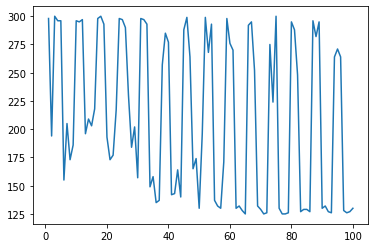

In [247]:
plt.plot(list(total_people.keys()),list(total_people.values()))

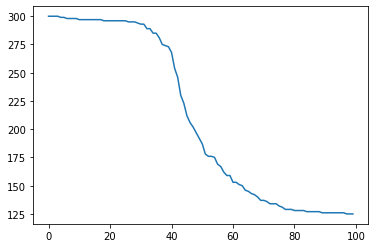

In [173]:
# Creating penalties related to the days that have the highest consumption with no accounting

# sort the days by the number of visitors
sorted_days = {k: v for k, v in sorted(total_people.items(), key=lambda item: item[1],reverse=True)}

plt.plot([i for i in range(100)],list(sorted_days.values()))

In [ ]:
# Write the penalties to file
with open('day_penalty.txt','w') as fout:
    fout.write('day\tpenalty\n')
    for k,v in sorted_days.items():
        fout.write('{}\t{}\n'.format(k,v/125))
        print('{}\t{}'.format(k,v/125))
        
        
    